# Class Exercise - MCTS with TSP
- Tal Zilkha - tiz2102
- Mat Hillman - mh3691

# MCTS

In [1374]:
import math
import numpy as np
EPS = 1e-8
import copy

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}       # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}       # stores #times edge s,a was visited
        self.Ns = {}        # stores #times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores game.getGameEnded ended for board s
        self.Vs = {}        # stores game.getValidMoves for board s
        
        self.val = [float('inf')]
        self.num_sim = [0]

    def getActionProb(self, state, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(state, i)

        s = self.game.stringRepresentation(state[-1])
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
        
        if temp==0:
            bestA = np.argmax(counts)
            probs = [0]*len(counts)
            probs[bestA]=1
            return probs

        counts = [x**(1./temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x/counts_sum for x in counts]
        return probs


    def search(self, state, num_sim):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(state[-1])
        
        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(state[-1])
        if self.Es[s]!=0:
            # terminal node
            return 0

        if s not in self.Ps:
            # leaf node
            if self.nnet is not None:
                if args['history']:
                    self.Ps[s], v = self.nnet.predict(state, self.game.graph)
                else:
                    self.Ps[s], v = self.nnet.predict(state[-1], self.game.graph)
            else:
                self.Ps[s] = np.ones(self.game.getActionSize()) # random policy
                v = 0
            valids = self.game.getValidMoves(state[-1])
            self.Ps[s] = self.Ps[s]*valids      # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s    # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable
                
                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print("All valid moves were masked, do workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s,a) in self.Qsa:
                    u = self.Qsa[(s,a)] + self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
                else:
                    u = self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s] + EPS)     # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, reward = self.game.getNextState(state[-1], a)
        new_history = copy.deepcopy(state)
        new_history.append(next_s)
        
        v = self.search(new_history, num_sim) + reward
        
        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1)
            self.Nsa[(s,a)] += 1

        else:
            self.Qsa[(s,a)] = v
            self.Nsa[(s,a)] = 1
            
        if self.game.getActionSize() - self.val[-1] < v:
            self.val += [self.game.getActionSize() - v]
            self.num_sim += [num_sim]

        self.Ns[s] += 1
        return v

# TSPGame

In [1322]:
from itertools import permutations 

class TSPGame():
    """
    This class specifies the base Game class. To define your own game, subclass
    this class and implement the functions below. This works when the game is
    two-player, adversarial and turn-based.
    Use 1 for player1 and -1 for player2.
    See othello/OthelloGame.py for an example implementation.
    """
    def __init__(self, args):
        self.num_node = args.num_node
        self.graph = np.random.rand(self.num_node, 2)

    def getStartState(self):
        """
        Returns:
            start_state: a representation of the graph
        """
        start_state = np.zeros([self.num_node, 2])
        start_state[0,0] = 1
        start_state[0,1] = 1
        return start_state

    def getActionSize(self):
        """
        Returns:
            self.num_node: number of all possible actions
        """
        return self.num_node

    def getNextState(self, state, action):
        """
        Input:
            state: current state
            action: action taken by current player
        Returns:
            next_state: graph after applying action
            reward: reward from action
        """
        next_state = state.copy()
        next_state[:, 1] = 0
        next_state[action, :] = 1
        prev_action = np.where(state[:, 1] == 1)[0][0]
        prev_node = self.graph[prev_action]
        cur_node = self.graph[action]
        reward = 1 - np.linalg.norm(cur_node - prev_node)
        if self.num_node == np.sum(next_state[:, 0]):
            reward += 1 - np.linalg.norm(cur_node - self.graph[0])
            
        return next_state, reward

    def getValidMoves(self, state):
        """
        Input:
            state: current state
        Returns:
            1 - state[:, 0]: a binary vector of length self.getActionSize(), 1 for
                            moves that are valid from the current board and player,
                            0 for invalid moves
        """
        return 1 - state[:, 0]

    def getGameEnded(self, state):
        """
        Input:
            state: current board state
        Returns:
            r: 0 if game has not ended. 1 if it has
               
        """
        r = 0
        if self.num_node == np.sum(state[:, 0]):
            r = 1
        return r

    def stringRepresentation(self, state):
        """
        Input:
            state: current state
        Returns:
            s: string representation of state
        """
        s = ''
        for i in range(self.num_node):
            s += str(int(state[i, 0]))
        return s
    
    def optimal_sol(self):
        """
        Input:
            
        Returns:
            optimal_val: optimal solution for TSP
            optimal_path: optimal path for TSP
        """
        cur_reward = 0
        optimal_val = float('inf')
        optimal_path = []
        graph = self.graph

        nodes = np.arange(self.num_node)[1:]
        perms = permutations(nodes)
        
        for perm in list(perms):
            cur_reward = 0
            
            cur_reward += np.linalg.norm(graph[0] - graph[perm[0]])
            for i in range(len(perm) - 1):
                j = perm[i]
                k = perm[i+1]
                cur_reward += np.linalg.norm(graph[k] - graph[j])
            cur_reward += np.linalg.norm(graph[perm[-1]] - graph[0])
            
            if optimal_val > cur_reward:
                optimal_val = cur_reward
                optimal_path = perm
        
        return optimal_val, optimal_path
    
    def create_sample(self):
        path = self.optimal_sol()[1]+tuple([0])
        current = self.getStartState()
        samples_v = []
        samples_pi = []
        tot_v = 0
        for i in path:
            pi = np.zeros(self.getActionSize())
            pi[i] = 1
            samples_pi.append((current, pi))
            next, v = self.getNextState(current, i)
            samples_v.append((current, v))
            current = next
        
        return samples_v, samples_pi
        
        

# Configuration

In [1503]:
class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

args = dotdict({
    # State representation
    'history': True,           # Whether state representation should be a history of states - used for lstm
    'history_length': None,     # If None full history
    
    # MCTS args
    'numMCTSSims': 500,        # Number of games moves for MCTS to simulate.
    'num_node': 7,              # Number of nodes in the graph (game)
    
    # Train args
    'numIters': 1,              # Number of episods to play (5 times 10 episodes)
    'numEps': 1,                # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 200000,    # Number of game examples to train the neural networks.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'numItersForTrainExamplesHistory': 25,
    
    # NN args
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 200,
    'batch_size': 64,
    'cuda': False,
    'num_channels': 512,
    })

# Self Play

In [1504]:
def play_game(args):
    game = TSPGame(args)
    mcts = MCTS(game, None, args)
    state = [game.getStartState()]
    mcts_reward = 0
    mcts_actions = []
    optimal_val, optimal_path = game.optimal_sol()
    while not game.getGameEnded(state[-1]):
        action = np.argmax(mcts.getActionProb(state))
        next_state, reward = game.getNextState(state[-1], action)
        state.append(next_state)
        mcts_actions += [action]
        mcts_reward += reward
        
#     print('Optimal Solution:', optimal_val)
#     print('Optimal Action:', optimal_path)
#     print('MCTS Reward:', game.getActionSize() - mcts_reward)
#     print('MCTS Action:', mcts_actions)
    
    return mcts.val, mcts.num_sim, optimal_val

# Plot

In [1505]:
val, num_sim, optimal_reward = play_game(args)
print(num_sim, val)

[0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 192, 192] [inf, 6.954028717293984, 6.365908149869855, 6.204589783654861, 5.760434948576108, 5.214586432099917, 4.781852115764927, 4.383845747692088, 4.222527381477094, 3.5884355313469496, 3.447847120221989, 2.8137552700918445]


Text(0,0.5,'Length')

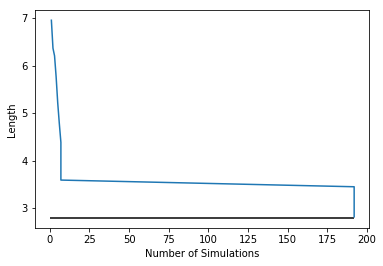

In [1506]:
import matplotlib.pyplot as plt

plt.plot(np.array(num_sim[1:]), val[1:])
plt.hlines(optimal_reward, 0, num_sim[-1])
plt.xlabel("Number of Simulations")
plt.ylabel("Length")

In [1507]:
# from collections import deque
# import time, os, sys
# from pickle import Pickler, Unpickler
# from random import shuffle


# class Coach():
#     """
#     This class executes the self-play + learning. It uses the functions defined
#     in Game and NeuralNet. args are specified in main.py.
#     """
#     def __init__(self, game, nnet, args):
#         self.game = game
#         self.nnet = nnet
#         self.args = args
#         self.mcts = MCTS(self.game, self.nnet, self.args)
#         self.trainExamplesHistory = []    # history of examples from args.numItersForTrainExamplesHistory latest iterations
#         self.skipFirstSelfPlay = False    # can be overriden in loadTrainExamples()

#     def executeEpisode(self):
#         """
#         This function executes one episode of self-play, starting with player 1.
#         As the game is played, each turn is added as a training example to
#         trainExamples. The game is played till the game ends. After the game
#         ends, the outcome of the game is used to assign values to each example
#         in trainExamples.

#         It uses a temp=1 if episodeStep < tempThreshold, and thereafter
#         uses temp=0.

#         Returns:
#             trainExamples: a list of examples of the form (canonicalBoard,pi,v)
#                            pi is the MCTS informed policy vector, v is +1 if
#                            the player eventually won the game, else -1.
#         """
#         trainExamples = []
#         board = [self.game.getStartState()]
#         episodeStep = 0

#         while True:
#             episodeStep += 1
#             temp = int(episodeStep < self.args.tempThreshold)

#             pi = self.mcts.getActionProb(board, temp=temp)

#             action = np.random.choice(len(pi), p=pi)
#             next_board, reward = self.game.getNextState(board[-1], action)
            
#             trainExamples.append([board, self.game.graph, pi, reward])
            
#             board.append(next_board)
            
#             r = self.game.getGameEnded(board[-1])
            
#             if r!=0:
#                 return [tuple(x) for x in trainExamples]
            
#     def learn(self):
#         """
#         Performs numIters iterations with numEps episodes of self-play in each
#         iteration. After every iteration, it retrains neural network with
#         examples in trainExamples (which has a maximum length of maxlenofQueue).
#         It then pits the new neural network against the old one and accepts it
#         only if it wins >= updateThreshold fraction of games.
#         """
#         for i in range(1, self.args.numIters+1):

#             if not self.skipFirstSelfPlay or i>1:
#                 iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

#                 for eps in range(self.args.numEps):
#                     self.mcts = MCTS(self.game, self.nnet, self.args)   # reset search tree
#                     iterationTrainExamples += self.executeEpisode()

#                 self.trainExamplesHistory.append(iterationTrainExamples)
                
#             if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
#                 print("len(trainExamplesHistory) =", len(self.trainExamplesHistory), " => remove the oldest trainExamples")
#                 self.trainExamplesHistory.pop(0)

#             # shuffle examples before training
#             trainExamples = []
#             for e in self.trainExamplesHistory:
#                 trainExamples.extend(e)
#             shuffle(trainExamples)
            
#         return trainExamples


In [1508]:
import sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [1738]:
# Inputs are in the form of a merged matrix of the graph and board

class ConvolutionalNN():
    def __init__(self, args):
        self.action_size = args['num_node']
        self.create_net()
        # Conv no history
        self.args = args
        self.args['history'] = False

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        print("Training...")
        input_boards, input_graphs, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray([boards[-1] for boards in input_boards])
        input_graphs = np.asarray(input_graphs)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        
        boards_graphs_list = [(input_graphs[i], input_boards[i]) for i in range(0, len(input_boards))] 
        input = [np.concatenate([*i], axis=1) for i in boards_graphs_list]
        self.model.fit(x = [input], y = [target_pis, target_vs], 
                       batch_size = args.batch_size, epochs = args.epochs, verbose=1)

    def predict(self, board, graph):
        """
        board: np array with board
        """        
        merged = np.concatenate([graph, board], axis=1)
        merged = merged[np.newaxis, :, :]
        
        # run
        pi, v = self.model.predict(merged)
        return pi[0], v[0]
    
    def create_net(self):
        # Neural Net
        self.input_boards = Input(shape=(self.action_size, 4))    # s: batch_size x board_x x board_y

        x_image = Reshape((self.action_size, 4, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
        h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
        h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
        h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
        h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
        h_conv4_flat = Flatten()(h_conv4)       
        s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
        s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
        self.v = Dense(1, activation='relu', name='v')(s_fc2)                    # batch_size x 1

        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))
         
    def save_model(self, filename):
        model_json = self.model.to_json()
        with open('saved_models/' + filename + ".json", "w") as json_file:
            json_file.write(model_json)
            
        # serialize weights to HDF5
        self.model.save_weights('saved_models/' + filename + ".h5")
        print("Saved model to disk")
        
    def load_model(self, filename):
        # load json and create model
        json_file = open('saved_models/' + filename + '.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        
        # load weights into new model
        self.model.load_weights('saved_models/' + filename + ".h5")
        print("Loaded model from disk")

In [1742]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

class RecurrentNN():
    def __init__(self, args):
        # game params
        self.action_size = args['num_node']
        self.num_node = args['num_node']
        self.board_size = (args['num_node'],2)
        self.args = args
        self.create_net()
        # Conv no history
        self.args['history'] = True
        
    def create_net(self):
        self.input_boards = Input(shape=(self.num_node, self.num_node*4))
        lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(self.input_boards)
        dense = Dense(128, activation='sigmoid')(lstm)
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(dense)
        self.v = Dense(1, activation='relu', name='v')(dense)
        
        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))        

    def predict(self, board_list, graph):
        input = self.prepare_input(board_list,graph)
        pi, v = self.model.predict(input)


        #print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return pi[0], v[0]
    
    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        print("Training...")
        input_boards, input_graphs, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray(input_boards)
        input_graphs = np.asarray(input_graphs)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        boards_graphs_list = [(input_boards[i], input_graphs[i]) for i in range(0, len(input_boards))] 
        prepared_inputs = np.asarray([self.prepare_input(*i)[0] for i in boards_graphs_list])
        self.model.fit(x = [prepared_inputs], y = [target_pis, target_vs], 
                       batch_size = args.batch_size, epochs = args.epochs, verbose=1)

    #
    # State representation is a history of states with the graph appended to them and the whole thing shaped to array.
    #
    #      [graph, visited, camefrom]  t0
    #      [graph, visited, camefrom]  t1
    #      [graph, visited, camefrom]  t2
    #      ..
    #      ..
    #      [graph, visited, camefrom]  tn
    #
    # Where tn is the current state and any timestamp that came before the first move is as such
    #      
    #      [graph,0,0]
    #
    
    def prepare_input(self,board_list, graph):
        if self.args['history_length'] is None:
            self.args['history_length'] = self.num_node
        while len(board_list)<self.args['history_length']:
            board_list = [np.zeros(self.board_size)] + board_list
        board_list = [x.transpose() for x in board_list]
        input = np.array(board_list).reshape(len(board_list), self.num_node*2)
        [graph]*self.num_node
        graph_data = np.array(([np.array(graph).reshape(self.num_node*2)]*len(board_list))).reshape(len(board_list), self.num_node*2)
        input = np.stack((np.array(graph_data), np.array(input)), axis=1).reshape(1,self.num_node,self.num_node*4)
        return(input)
    
    def save_model(self, filename):
        model_json = self.model.to_json()
        with open('saved_models/' + filename + ".json", "w") as json_file:
            json_file.write(model_json)
            
        # serialize weights to HDF5
        self.model.save_weights('saved_models/' + filename + ".h5")
        print("Saved model to disk")
        
    def load_model(self, filename):
        # load json and create model
        json_file = open('saved_models/' + filename + '.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        
        # load weights into new model
        self.model.load_weights('saved_models/' + filename + ".h5")
        print("Loaded model from disk")
        

In [1511]:
# def play_game_with_nn(args, nn):
#     game = TSPGame(args)
#     mcts = MCTS(game, nn, args)
#     state = [game.getStartState()]
#     mcts_reward = 0
#     mcts_actions = []
#     optimal_val, optimal_path = game.optimal_sol()
    
#     while not game.getGameEnded(state[-1]):
#         action = np.argmax(mcts.getActionProb(state))
#         next_state, reward = game.getNextState(state[-1], action)
#         state+=[next_state]
#         mcts_actions += [action]
#         mcts_reward += reward
        
# #     print('Optimal Solution:', optimal_val)
# #     print('Optimal Action:', optimal_path)
# #     print('MCTS Reward:', game.getActionSize() - mcts_reward)
# #     print('MCTS Action:', mcts_actions)
    
#     return mcts.val, mcts.num_sim, optimal_val

In [ ]:
# build training dataset
def create_training_set(args, n_games = 100):
    data_set = []
    for i in range(n_games):
        t = TSPGame(args)
        train_v, train_pi = t.create_sample()
        for i in range(1,len(train_v)):
            boards = [j[0] for j in train_v[:i]]
            graph = t.graph
            data_set+=[(boards, graph, train_pi[i-1][1], train_v[i-1][1])]
    return data_set
            
dataset = create_training_set(args, 1000)

In [1513]:
rnn = RecurrentNN(args)
# cnn = ConvolutionalNN(args)
rnn.train(dataset)
# cnn.train(dataset)

Training...
Epoch 1/200
60000/60000 [==============================] - 112s 2ms/step - loss: 1.5003 - pi_loss: 1.2786 - v_loss: 0.2218
Epoch 2/200
60000/60000 [==============================] - 82s 1ms/step - loss: 1.1825 - pi_loss: 1.1250 - v_loss: 0.0576
Epoch 3/200
60000/60000 [==============================] - 79s 1ms/step - loss: 1.1610 - pi_loss: 1.1073 - v_loss: 0.0537
Epoch 4/200
60000/60000 [==============================] - 79s 1ms/step - loss: 1.1501 - pi_loss: 1.0982 - v_loss: 0.0519
Epoch 5/200
60000/60000 [==============================] - 79s 1ms/step - loss: 1.1420 - pi_loss: 1.0913 - v_loss: 0.0507
Epoch 6/200
60000/60000 [==============================] - 78s 1ms/step - loss: 1.1364 - pi_loss: 1.0863 - v_loss: 0.0501
Epoch 7/200
60000/60000 [==============================] - 78s 1ms/step - loss: 1.1282 - pi_loss: 1.0782 - v_loss: 0.0500
Epoch 8/200
60000/60000 [==============================] - 78s 1ms/step - loss: 1.1204 - pi_loss: 1.0711 - v_loss: 0.0493
Epoch 9/200

60000/60000 [==============================] - 63s 1ms/step - loss: 0.7125 - pi_loss: 0.6694 - v_loss: 0.0431
Epoch 67/200
60000/60000 [==============================] - 64s 1ms/step - loss: 0.7091 - pi_loss: 0.6660 - v_loss: 0.0431
Epoch 68/200
60000/60000 [==============================] - 64s 1ms/step - loss: 0.7078 - pi_loss: 0.6649 - v_loss: 0.0429
Epoch 69/200
60000/60000 [==============================] - 62s 1ms/step - loss: 0.7031 - pi_loss: 0.6598 - v_loss: 0.0433
Epoch 70/200
60000/60000 [==============================] - 62s 1ms/step - loss: 0.7041 - pi_loss: 0.6611 - v_loss: 0.0430
Epoch 71/200
60000/60000 [==============================] - 61s 1ms/step - loss: 0.7048 - pi_loss: 0.6620 - v_loss: 0.0428
Epoch 72/200
60000/60000 [==============================] - 61s 1ms/step - loss: 0.7010 - pi_loss: 0.6580 - v_loss: 0.0430
Epoch 73/200
60000/60000 [==============================] - 60s 998us/step - loss: 0.6966 - pi_loss: 0.6538 - v_loss: 0.0428
Epoch 74/200
60000/60000 [=

60000/60000 [==============================] - 62s 1ms/step - loss: 0.6153 - pi_loss: 0.5743 - v_loss: 0.0410
Epoch 133/200
60000/60000 [==============================] - 62s 1ms/step - loss: 0.6134 - pi_loss: 0.5720 - v_loss: 0.0414
Epoch 134/200
60000/60000 [==============================] - 61s 1ms/step - loss: 0.6156 - pi_loss: 0.5742 - v_loss: 0.0413
Epoch 135/200
60000/60000 [==============================] - 61s 1ms/step - loss: 0.6120 - pi_loss: 0.5710 - v_loss: 0.0411
Epoch 136/200
60000/60000 [==============================] - 61s 1ms/step - loss: 0.6120 - pi_loss: 0.5705 - v_loss: 0.0415
Epoch 137/200
60000/60000 [==============================] - 61s 1ms/step - loss: 0.6076 - pi_loss: 0.5664 - v_loss: 0.0412
Epoch 138/200
60000/60000 [==============================] - 60s 1ms/step - loss: 0.6064 - pi_loss: 0.5654 - v_loss: 0.0411
Epoch 139/200
60000/60000 [==============================] - 62s 1ms/step - loss: 0.6113 - pi_loss: 0.5701 - v_loss: 0.0413
Epoch 140/200
60000/60

60000/60000 [==============================] - 63s 1ms/step - loss: 0.5599 - pi_loss: 0.5196 - v_loss: 0.0403
Epoch 197/200
60000/60000 [==============================] - 59s 978us/step - loss: 0.5626 - pi_loss: 0.5228 - v_loss: 0.0398
Epoch 198/200
60000/60000 [==============================] - 59s 976us/step - loss: 0.5629 - pi_loss: 0.5231 - v_loss: 0.0397
Epoch 199/200
60000/60000 [==============================] - 58s 973us/step - loss: 0.5618 - pi_loss: 0.5218 - v_loss: 0.0399
Epoch 200/200
60000/60000 [==============================] - 58s 970us/step - loss: 0.5599 - pi_loss: 0.5200 - v_loss: 0.0400


In [1709]:
# Given a dictionary of MCTSs and a Game, returns a dictionary of each models best results over number of simulations
def evaluation_run(game, MCTSs):
    results = {}
    optimal_val, optimal_path = game.optimal_sol()
    for model in MCTSs.keys():
        state = [game.getStartState()]
        mcts_reward = 0
        mcts_actions = []
        
        while not game.getGameEnded(state[-1]):
            action = np.argmax(MCTSs[model].getActionProb(state))
            next_state, reward = game.getNextState(state[-1], action)
            state+=[next_state]
            mcts_actions += [action]
            mcts_reward += reward
        results[model] = copy.deepcopy((MCTSs[model].val, MCTSs[model].num_sim))
    return results, optimal_val   

# Given MCTS results and optimal solution returns a pandas series of the commulative number of games where a solution
# within a threshold of the optimal was found per number of simulations
def add_entry(model_results, optimal, args):
    count_v = np.zeros(args['numMCTSSims']+1)
    for i,j in enumerate(model_results[1]): count_v[j] = model_results[0][i]
    return ((pd.Series(count_v).replace(to_replace=0, method='ffill')/optimal)<1.1)*1

# Given games and neural nets, runs models on games and computes the number of games which a solution was found
# within a threshold of the optimal
#
# games - a list of games to test on the models
# nets - a dictionaryu of the neural nets to be tested, None for no net
# args - argument dictionary
def create_comparison(games, nets, args):
    totals = {nn:pd.Series(np.zeros(args['numMCTSSims']+1)) for nn in nets.keys()}
    for i,game in enumerate(games):
        print(i, end='...')
        mcts_dic = {nn:MCTS(game, nets[nn], args) for nn in nets.keys()}
        results, optimal = evaluation_run(game, mcts_dic)
        for model in totals.keys():
            totals[model] += (add_entry(results[model], optimal, args))
    for model in totals.keys():
        totals[model]/=len(games)
    print()
    return totals

# Prints results from create_comparison
def plot_comparison(res):
    for model in res.keys():
        plt.plot(list(range(len(res[model]))), res[model])
    plt.xlabel("Number of Simulations")
    plt.ylabel("Percentage of Games within Threshold")
    plt.legend(res.keys())
    plt.show()

In [1745]:
%%time

args['numMCTSSims']=1000

game_list = [TSPGame(args) for i in range(100)]

nets = {"No NN": None, 
          "LSTM": rnn}

res = create_comparison(game_list, nets, args)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...
CPU times: user 9min 19s, sys: 34.3 s, total: 9min 53s
Wall time: 9min 3s


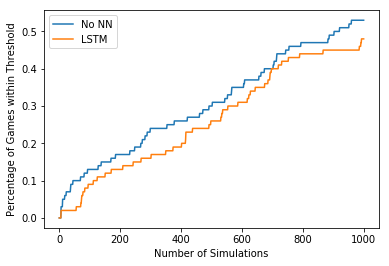

In [1746]:
plot_comparison(res)

In [1743]:
rnn = RecurrentNN(args)

In [1744]:
rnn.load_model('model')

Loaded model from disk


In [1723]:
rnn.model.save_weights('model.h5')
with open("model.json", "w") as json_file:
    json_file.write(rnn.model.to_json())

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [1716]:
rnn.model.to_json()

'{"class_name": "Model", "config": {"name": "model_157", "layers": [{"name": "input_166", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 7, 28], "dtype": "float32", "sparse": false, "name": "input_166"}, "inbound_nodes": []}, {"name": "lstm_154", "class_name": "LSTM", "config": {"name": "lstm_154", "trainable": true, "dtype": "float32", "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 128, "activation": "tanh", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null, "dtype": "float32"}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null,